# Stochastic Poker Models

In [1]:
#imports
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

### Recurring functions

In [2]:
#function for computing a weighted average and weighted standard deviation
def weighted_avg_and_sd(values, weights):
    avg = np.average(values, weights=weights)
    var = np.average((values-avg)**2, weights=weights)
    sd = var**.5
    return (avg, sd)


## Model allowing multiple stakes to be played:

This first model allows multiple stakes or game types with different winrates or standard deviations to be played, which the primedope model does not support. The inputs for stakes are meant to be in dollars and the individual entries represent the dollar amounts of the big blind (bb). Inputs for the winrates and standard deviations are given per 100 hands, as is the standard in poker software. About 250k hands are needed for the standard deviation on the realized winrate in the sample to drop below 2bb/100 hands. Hence, the a priori estimate of a player's true winrate is likely to be the limiting factor in model accuracy.

The distribution of winnings from individual hands is assumed to follow a normal distribution. This is far from the case in reality, as moves of 10 standard deviations occur once every 100 or 200 hands on average, but it is convenient to assume and after only a few hundred hands we get a reasonable convergence to a normal distribution because of the Central Limit theorem. Justification is found towards the end of the notebook.

The outputs for this model mostly follow from the properties of the sums of iid distributions; the means and the variances sum so the standard deviation of the sum scales with the square root of the number of elements in the sum. This allows outputs to be computed in constant time. 

EV: 82000.00
Standard deviation of winnings: 39242.83
Sharpe ratio: 2.09
70% confidence interval on winnings: [41327.42, 122672.58]
95% confidence interval on winnings: [5085.46, 158914.54]
99% confidence interval on winnings: [-19082.84, 183082.84]


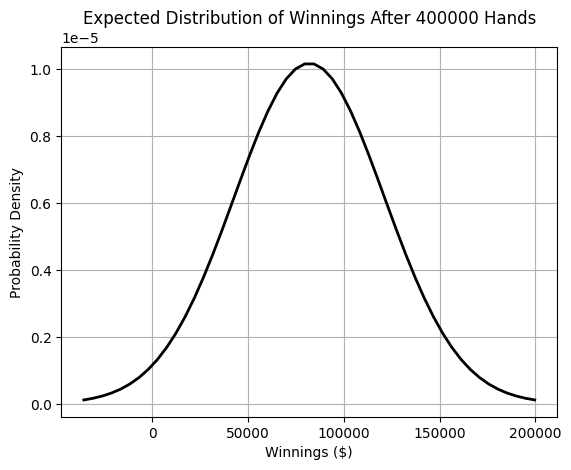

In [3]:
stake_bb_value = np.array([2,5,10])            #stake_bb_value[i] represents the big blind value (in $) for the ith stake
n_hands = np.array([100000,200000,100000])     #number of hands to be played at each stake

#winrate and standard deviation in bb per 100 hands corresponding to each stake.
winrates_100 = np.array([6,4,3])               #Values from 2 to 8 typical for pros.
sd_100 = np.array([100,100,100])               #Values around 100 are typical for 6 handed no-limit hold'em games.


#Computing the standard deviation and winrate values per hand
sd = sd_100*.1                                 #the standard deviation scales with the square root of the number of hands
winrates = winrates_100*.01                  

stake_mean = n_hands*stake_bb_value*winrates   #The EV at each stake in $ is given by scaling the EV in big blinds by the stake_bb_value
total_mean = sum(stake_mean)                   #total EV across the stakes
print(f"EV: {total_mean:.2f}")


#Array with the ith entry representing the standard deviation (in $) of the results at the ith stake, obtained by scaling the sd value in bb by the stake_bb_value.
stake_sigma = n_hands**.5*stake_bb_value*sd                        
total_sigma = (np.sum(stake_sigma*stake_sigma))**.5                #Sum the variances across all stakes and take the square root to get the total sd

print(f"Standard deviation of winnings: {total_sigma:.2f}")
print(f"Sharpe ratio: {total_mean/total_sigma:.2f}")


mu, sigma = total_mean, total_sigma                                #Parameters for the Gaussian distribution of winnings

#confidence intervals
conf_70 = [-(norm.ppf(0.85))*sigma + mu, (norm.ppf(0.85))*sigma + mu]
conf_95 = [-(norm.ppf(0.975))*sigma + mu, (norm.ppf(0.975))*sigma + mu]
conf_99 = [-(norm.ppf(0.995))*sigma + mu, (norm.ppf(0.995))*sigma + mu]

print(f"70% confidence interval on winnings: [{conf_70[0]:.2f}, {conf_70[1]:.2f}]")
print(f"95% confidence interval on winnings: [{conf_95[0]:.2f}, {conf_95[1]:.2f}]")
print(f"99% confidence interval on winnings: [{conf_99[0]:.2f}, {conf_99[1]:.2f}]")

#Plotting the distribution
plt.xlabel('Winnings ($)')
plt.ylabel('Probability Density')
plt.title(f'Expected Distribution of Winnings After {sum(n_hands)} Hands')
plt.grid(True)

x = np.linspace(mu - 3*sigma, mu + 3*sigma)
y = norm.pdf(x, mu, sigma)                                 

plt.plot(x, y, 'k', linewidth=2)

plt.show()


### Here are some simulated runs with inputs taken from the previous model:

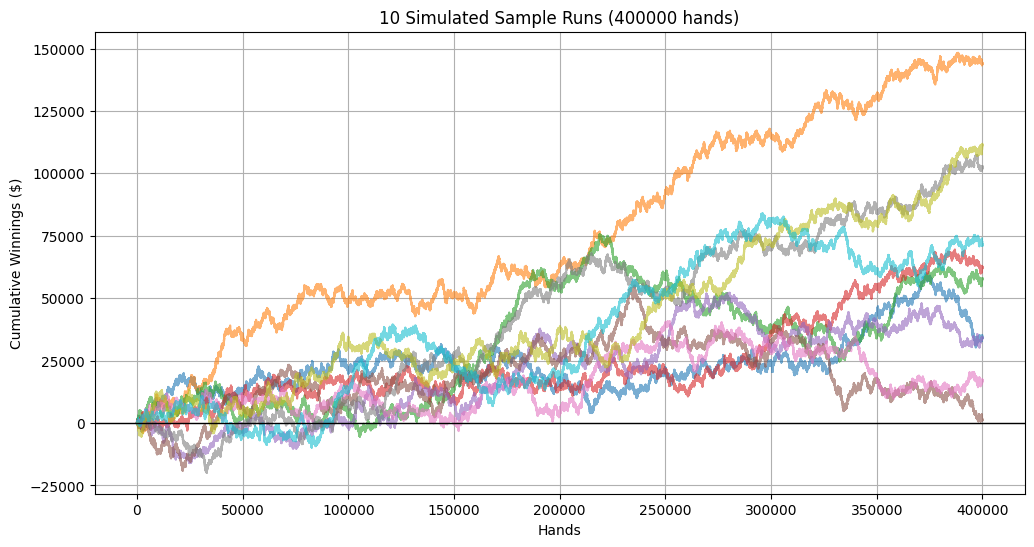

In [4]:
#simulating a single run
def simulate_run(stakes, wrs, sds, hands):
    total_sample = np.array([])
    
    # Simulate the hands at each stake separately
    for i, stake in enumerate(stake_bb_value):
        stake_sim = np.random.normal(wrs[i], sds[i], size=hands[i])         #Simulate all hands at the ith stake
        stake_sim = stake*stake_sim                                         #Scale by the big blind value of stake to get the win/loss per hand
        total_sample = np.concatenate((total_sample, stake_sim))            #Append the hand sample at the given stake
        
    np.random.shuffle(total_sample)                                         #Shuffle the sample so hands appear in random order
    run = np.cumsum(total_sample)                                           
    return run


def plot_multiple_runs(stakes, wrs, sds, hands, runs):
    plt.figure(figsize=(12, 6))

    for i in range(runs):
        run = simulate_run(stakes=stakes, wrs=wrs, sds=sds, hands=hands)
        plt.plot(run, alpha=0.6)

    plt.title(f"{runs} Simulated Sample Runs ({sum(n_hands)} hands)")
    plt.xlabel("Hands")
    plt.ylabel("Cumulative Winnings ($)")
    plt.grid(True)
    plt.axhline(0, color="black", linewidth=1)
    plt.show()

plot_multiple_runs(stakes=stake_bb_value, wrs=winrates, sds=sd, hands=n_hands, runs=10)


## Simulating a bad beat jackpot (BBJ):

This next model allows for the possibility of simulating a BBJ and computing it's effect on the variance and distribution of winnings. The default inputs for the BBJ payouts approximate the values found at GG Poker and the jackpot is assumed to be 0 EV. The effect on the variance of adding a BBJ is massive; it increases it by about 30%. However, the BBJ distribution is skewed right, and the loss is capped by the BBJ rake (which is about 2bb/100hands for GG Poker), so the standard deviation of the winnings or something like a Sharpe ratio do not capture the whole picture. 

The compute the BBJ hit frequency, we assume that `bbj_pool` is the long term average of what the BBJ prize pool sits at. We then equate the BBJ rake paid by each table per hand with the total table payout when the bbj hits. This is a bit of a backward approach, but should be fairly accurate.

In each of the `n_sims`, we individually simulate n_hands BBJ and hand outcomes, which results in a O(`n_hands*n_sims`) time complexity. One possibility for improving this would be to model the results from the `n_hands` hands in each simulation as a single draw from a normal distribution, like in the first model, with the BBJ rake subtracted from the winrate. We could then randomly allocate the expected number of BBJ jackpots (corresponding to `n_sims*n_hands` total hands) to individual simulations through a lottery, provided we took `n_sims` sufficiently large. This would lead to an improved O(`n_sims`) time complexity.

Inputs and outputs are in big blinds.

 The BBJ hit probability is 0.0000123, which equates to once per 81000.0 hands


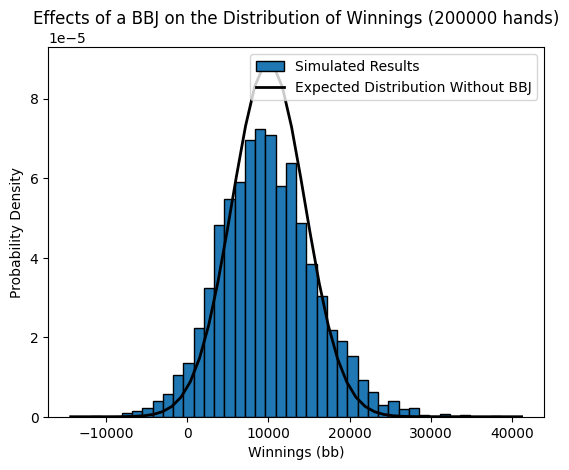

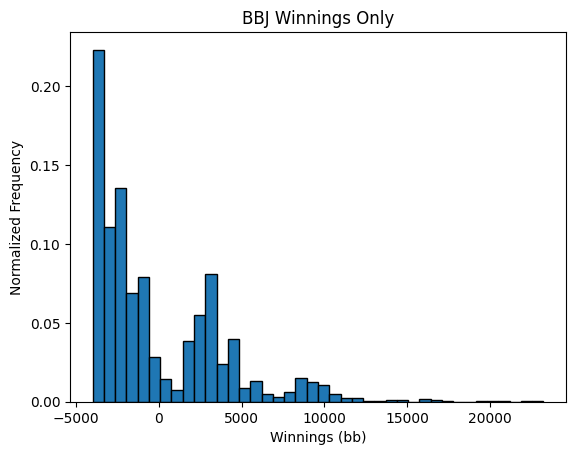

The standard deviation of the hands only is 4472.14, and the corresponding Sharpe ratio is 2.24
The standard deviation of the BBJ results is 4065.40
The standard deviation of the total results is 6043.80, and the corresponding Sharpe ratio is 1.65
The simulated results at the [10, 25, 50, 75, 90] percentiles for the hands only: [ 4310.8  7075.  10090.5 13130.2 15592.7]
The simulated results at the [10, 25, 50, 75, 90] percentiles for the BBJ only: [-3519. -3039. -1719.  2480.  4760.]
The simulated results at the [10, 25, 50, 75, 90] percentiles for both the hands and BBJ: [ 2813.6  5869.5  9603.5 13530.5 17440.6]


In [5]:
winrate_100 = 5
sd_100 = 100

winrate = .01*winrate_100      
sd = .1*sd_100

n_hands = 200000
n_sims = 3000

bbj_pool = 60000                                                       #BBJ pool in bb. Corresponds to the jackpot pool per stake on GG Poker
payout_percent_of_pool = np.array([.008, .008, .008, .008, .03, .1])   #Taken from the GG values: 0.8% for table share, 3% winning hand, 10% losing hand
bbj_rake_per_hand = 0.02                                                    #2bb/100hands rake
bbj_hit_freq = bbj_pool*sum(payout_percent_of_pool)/(6*bbj_rake_per_hand)   #Total amount won by the table on a BBJ divided by the BBJ rake paid by the table
bbj_hit_prob = 1/bbj_hit_freq

print(f' The BBJ hit probability is {bbj_hit_prob:.7f}, which equates to once per {bbj_hit_freq:.1f} hands')


#When we hit the BBJ 4/6 times we get the table share, 1/6 the winning hand, 1/6 the losing hand
bbj_payout_probs = (1/bbj_hit_freq)*np.array([bbj_hit_freq - 1, 4/6, 1/6, 1/6])
bbj_payouts = np.array([-0.02, .008 * bbj_pool, .03*bbj_pool, .1*bbj_pool])

def simulation(n_sims, n_hands, winrate, sd):
    mu = winrate
    sigma = sd
    
    total_results = np.array([0]*n_sims)       #hands and bbj result for each simulation on n_hands
    hands_only = np.array([0]*n_sims)          #hands with no bbj results
    bbj_only = np.array([0]*n_sims)
    
    #We simulate the hands and BBJ separately and take their sum as the total result
    for i in range(n_sims):
        hands_sim = sum(np.random.normal(mu, sigma, size=n_hands))                           #Single simulation consisting of n_hands
        bbj_sim = sum(np.random.choice(bbj_payouts, size=n_hands, p=bbj_payout_probs))
        hands_only[i] = hands_sim
        bbj_only[i] = bbj_sim
        total_results[i] = hands_sim + bbj_sim
    
    return (total_results, hands_only, bbj_only)

#Run the simulation
total_results, hands_only, bbj_only = simulation(n_sims, n_hands, winrate, sd)


#plotting a histogram of the total results after n_hands
plt.hist(total_results, bins=40, edgecolor='black', density=True, label='Simulated Results')

plt.xlabel('Winnings (bb)')
plt.ylabel('Probability Density')
plt.title(f'Effects of a BBJ on the Distribution of Winnings ({n_hands} hands)')

#Setting the mean and sd of the limit normal distribution for the hands played only.
mu, sigma = winrate*n_hands, sd*n_hands**.5

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)

#Normal distribution
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'k', linewidth=2, label='Expected Distribution Without BBJ')
plt.legend()

plt.show()


#BBJ only results
weights = np.ones_like(bbj_only) / len(bbj_only)
plt.hist(bbj_only, bins=40, edgecolor='black', weights=weights)

plt.xlabel('Winnings (bb)')
plt.ylabel('Normalized Frequency')
plt.title('BBJ Winnings Only')

plt.show()


bbj_only_sd = weighted_avg_and_sd(bbj_payouts, bbj_payout_probs)[1]*n_hands**.5        
hands_only_sd = sigma
total_sd = (bbj_only_sd**2 + hands_only_sd**2)**.5                                      #the bbj results and hand results are independent

print(f"The standard deviation of the hands only is {hands_only_sd:.2f}, and the corresponding Sharpe ratio is {mu/hands_only_sd:.2f}")
print(f"The standard deviation of the BBJ results is {bbj_only_sd:.2f}")                #The EV of the BBJ is 0, so the Shape is 0
print(f"The standard deviation of the total results is {total_sd:.2f}, and the corresponding Sharpe ratio is {mu/total_sd:.2f}")

percentiles = [10,25,50,75,90]

#Results from the simulated hand samples
print(f"The simulated results at the {percentiles} percentiles for the hands only: {np.round(np.percentile(hands_only, percentiles), 1)}")
print(f"The simulated results at the {percentiles} percentiles for the BBJ only: {np.round(np.percentile(bbj_only, percentiles), 1)}")
print(f"The simulated results at the {percentiles} percentiles for both the hands and BBJ: {np.round(np.percentile(total_results, percentiles), 1)}")


## Model that allows movement between stakes:

This next model allows for moving up and down in stakes when certain bankroll threshold conditions are met. It can possibly be used for stuff like helping to find a fair staking arrangement between a player and a backer if the player is moving up in stakes. We simulate the outcome of each hand individually, as we need to check if the conditions for moving up and down stakes are met after each hand, which will have O(`n_hands*n_sims`) time complexity.

If we are playing a single stake, the resulting distribution is normal. On the other hand, if we keep the same winrates and standard deviations constant across stakes, we play a large number of stakes, and the ratios of the thresholds for moving up or down stay roughly constant, we should get distribution close to a log-normal. 

WARNING: Simulating these outcomes is SLOW and Python is probably not the ideal language for this. Speed could also be improved by simulating batches of hands rather than individual hands, like in the first model, with the batch size dynamically chosen at each step so that the probability of crossing a `stake_thresholds` is sufficiently close to zero. 

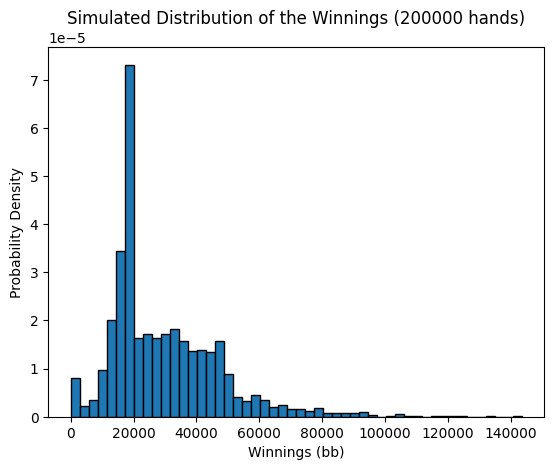

The simulated results at the [10, 25, 50, 75, 90] percentiles are: [13304.  17721.  23989.  39309.2 49718.6]
The proportion of runs resulting in ruin is 0.021 


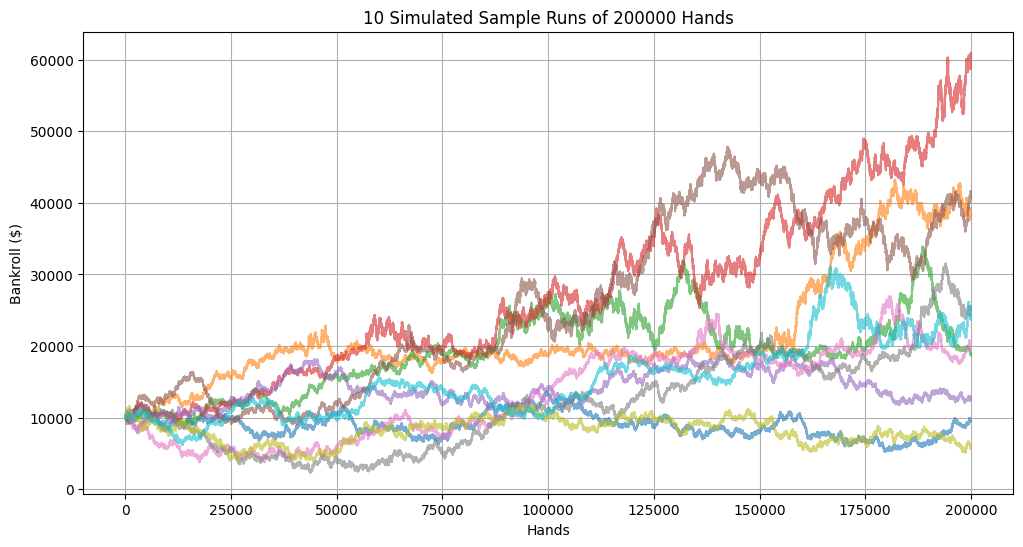

In [6]:
n_hands = 200000                                 #number of hands simulated
n_sims = 3000                                    #number of simulations, each of n_hands
initial_bankroll = 10000
stakes = np.array([2,5,10])                  #Stake big blind values. Must be in increasing order
stake_thresholds = np.array([20000,50000])   #We up or down from stake[i] to stake[i+1] when our bankroll crosses stake_thresholds[i]. Must be in increasing order
winrates_100 = np.array([4,3,2])
sd_100 = np.array([100,100,100])

winrates = winrates_100*.01
sd = sd_100*.1

initial_index = 0                           #index of the stake at our starting bankroll
#find the initial stake
while initial_index < len(stakes) -1 and stake_thresholds[initial_index] < initial_bankroll:
    initial_index += 1


#If return_run == True, we return an array representing a simulated run. Otherwise we return the result only.
#After each hand, we check if the conditions are met for moving up or down
def single_simulation(n_hands, return_run):
    current_bankroll = initial_bankroll               #Keep track of our current bankroll
    current_index = initial_index                     #Keep track of the current stake we play
    if return_run == False:
        for i in range(n_hands):
            current_bankroll += np.random.normal(winrates[current_index], sd[current_index])*stakes[current_index]
            if current_bankroll <= 0:
                return 0 
            elif current_index < len(stakes) - 1 and current_bankroll >= stake_thresholds[current_index]:
                current_index += 1
            elif current_index > 0  and current_bankroll < stake_thresholds[current_index - 1]:
                current_index -= 1
        return current_bankroll 
    else:
        run = np.array([0]*n_hands)                    
        run[0] = initial_bankroll                    #Start the run at our initial bankroll 
        for i in range(n_hands):
            current_bankroll += np.random.normal(winrates[current_index], sd[current_index])*stakes[current_index]
            run[i] = current_bankroll
            if current_bankroll <= 0:
                return run
            elif current_index < len(stakes) - 1 and current_bankroll >= stake_thresholds[current_index]:
                current_index += 1
            elif current_index > 0  and current_bankroll < stake_thresholds[current_index - 1]:
                current_index -= 1
        return run 

        
#If plot_runs == True, we return plot n_sims simulated runs. Otherwise we return an array of size n_sims representing the results of the simulations.
def multiple_simulations(n_sims, plot_runs):
    if plot_runs == False:
        sims = np.array([0]*n_sims)            #our n_sims simulations
        for i in range(n_sims):
            sim = single_simulation(n_hands, return_run = False)
            sims[i] = sim
        return sims
    else:
        plt.figure(figsize=(12, 6))
        for i in range(n_sims):
            run = single_simulation(n_hands, return_run = True)
            plt.plot(run, alpha=0.6)

        plt.title(f"{n_sims} Simulated Sample Runs of {n_hands} Hands")
        plt.xlabel("Hands")
        plt.ylabel("Bankroll ($)")
        plt.grid(True)
        plt.show()

sims = multiple_simulations(n_sims, plot_runs=False)

#plot the histogram of the n_sims simulations of n_hands
plt.hist(sims, bins=50, edgecolor='black', density = True)

plt.xlabel('Winnings (bb)')
plt.ylabel('Probability Density')
plt.title(f'Simulated Distribution of the Winnings ({n_hands} hands)')

plt.show()

percentiles = [10,25,50,75,90]

#Results from the simulated hand samples
print(f"The simulated results at the {percentiles} percentiles are: {np.round(np.percentile(sims, percentiles), 1)}")

#Find the fraction of runs where the bankroll hits 0
ruined = sims[sims <= 0]
risk_of_ruin = len(ruined)/len(sims)
print(f"The proportion of runs resulting in ruin is {risk_of_ruin:.3f} ")

multiple_simulations(10, plot_runs=True)

## Justification for the normal distribution assumption of hand results:

I use a sample of 600k no-limit hold'em hands I've played in a PokerTracker 4 database, with the average win/loss normalized to 0, to model the true distribution of pot sizes and their associated probabilities. The `empirical_sd` of 10 big blinds per hand corresponds to 100 per 100 hands, which is approximately the average standard deviation in 6-handed no-limit hold'em games. After a few hundred hands, the limit normal distribution (given by the CLT) with $\mu$ = `empirical_mean` and $\sigma$ = `empirical_sd*n_hands**.5` closely approximates the simulated distribution of winnings.

True winrate and standard deviation per hand: 0.00, 10.05


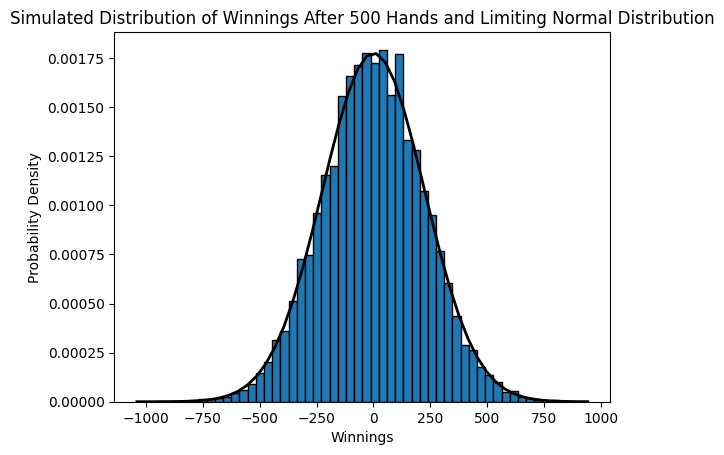

In [7]:
n_hands = 500                                                                          #number of hands to be simulated for each simulation batch
n_sims = 10000                                                                         #number of simulation batches, each with n_hands
win_loss = np.array([-100, -30, -10, -3, -1, 0, 1, 3, 10, 30, 100])                    #empirical win and loss sizes bb
win_loss_probs = 0.01*np.array([.35, 1.3, 3, 7, 16.5, 43.7, 16.5, 7, 3, 1.3, .35])     #empirical win/loss frequencies

#plt.hist(win_loss_probs, bins = win_loss, width=bin_width, edgecolor='black')
#plt.show()

def simulation(n_sims, n_hands):
    sims = np.array([0]*n_sims)
    for i in range(n_sims):
        sim = np.random.choice(win_loss, size=n_hands, p=win_loss_probs)
        sims[i] = sum(sim)
    return sims

#running n_sims iterations of the simulation, each simulating n_hands from the empirical win/loss distribution
sims = simulation(n_sims, n_hands)

#plotting a histogram of the simulated wins/losses in bb after n_hands
plt.hist(sims, bins=50, edgecolor='black', density = True)

# Plotting the results
plt.xlabel('Winnings')
plt.ylabel('Probability Density')
plt.title(f'Simulated Distribution of Winnings After {n_hands} Hands and Limiting Normal Distribution')


empirical_mean, empirical_sd = weighted_avg_and_sd(win_loss, win_loss_probs)    #True winrate and sd per hand, based on data provided
print(f"True winrate and standard deviation per hand: {empirical_mean:.2f}, {empirical_sd:.2f}")

mu, sigma = empirical_mean*n_hands, empirical_sd*n_hands**.5                        #Expected limiting distribution for samples of n_hands.

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)

#Limit normal distribution
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'k', linewidth=2)

plt.show()